## Apakah Benar Wanita Lebih Suka Membeli produk Beauty dibandingkan dengan Clothing

Hari ini melalui dataset ritel yang saya dapatkan, saya akan mencoba melakukan beberapa uji statistik untuk mendapatkan insight yang dapat digunakan untuk menenetukan strategi toko ritel kita kedepannya.
Statistical data analysis kali ini akan menjawab pertanyaan tentang
- Apakah gender memberi dampak total penjualan toko ?
- Apakah tingkat usia pelanggan juga memiliki pengaruh terhadap penjualan toko ?
- Produk apa yang cenderung dibeli oleh konsumen di toko kita ?
- Benarkan wanita/pria cenderung memilih jenis produk tertentu ?

**Import Library & Dataset**

In [1]:
import pandas as pd
import numpy as np


In [59]:
!pip install pandas openpyxl



[notice] A new release of pip is available: 23.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
df = pd.read_csv('retail_sales_dataset.csv')
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [4]:
df.isnull().sum()

Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

**Exploratory Data Analysis**

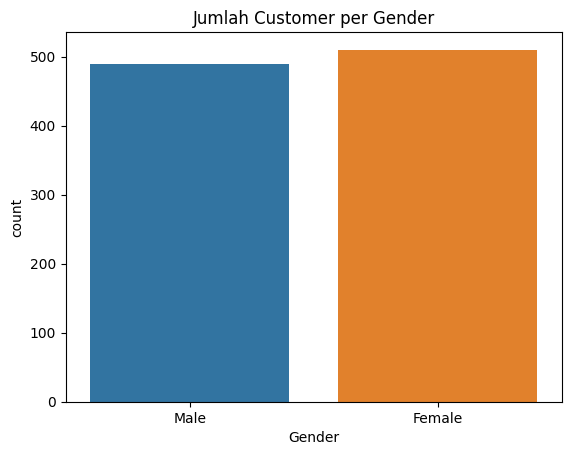

In [5]:
df_unique_customers = df.drop_duplicates(subset='Customer ID')

sns.countplot(x='Gender', data=df_unique_customers)
plt.title("Jumlah Customer per Gender")
plt.show()

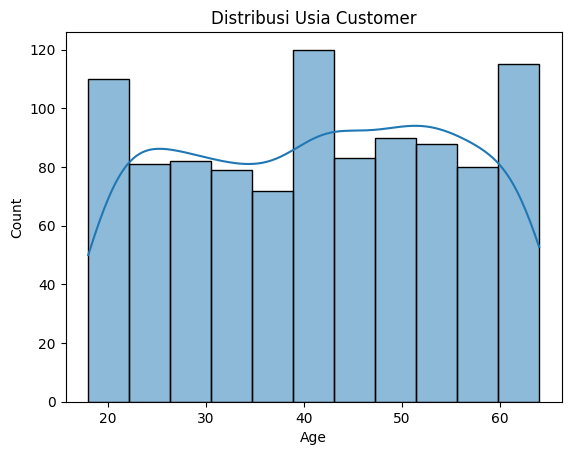

In [6]:
sns.histplot(df_unique_customers['Age'], kde=True)
plt.title('Distribusi Usia Customer')
plt.show()

Text(0.5, 1.0, 'Distribusi Total Spend Tiap Kustomer')

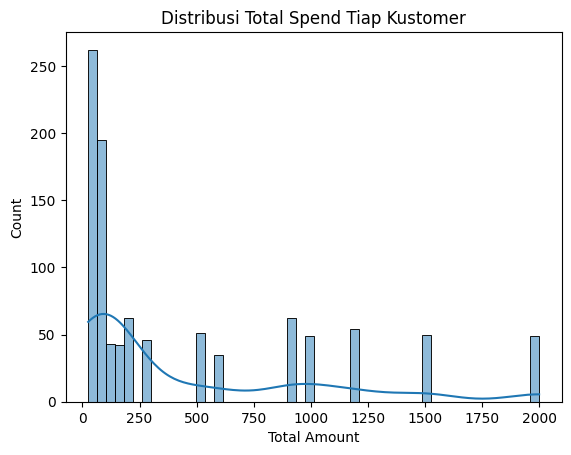

In [7]:
sns.histplot( df.groupby('Customer ID')['Total Amount'].sum() , bins=50, kde=True)

plt.title('Distribusi Total Spend Tiap Kustomer')

In [8]:
df.groupby('Product Category')['Quantity'].sum().sort_values(ascending=False)

Product Category
Clothing       894
Electronics    849
Beauty         771
Name: Quantity, dtype: int64

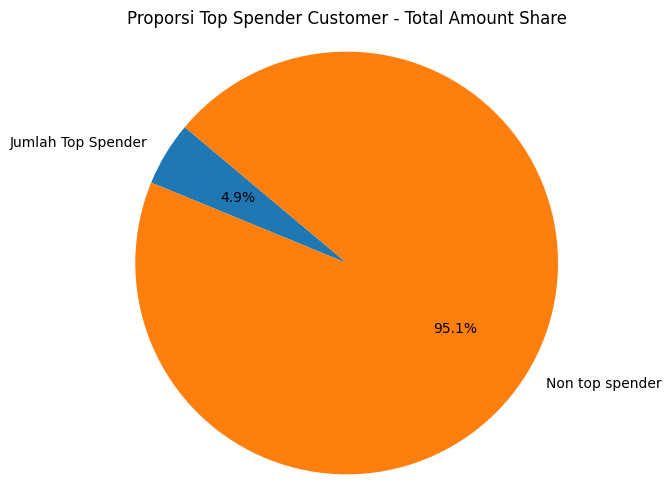

In [9]:

customer_total = df.groupby('Customer ID')['Total Amount'].sum()
#customer_total = df.groupby('Customer ID')['Total Amount'].sum().sort_values(ascending=False).head(15)
# Filter customer dengan total = 2000
customer_2000 = customer_total[customer_total == 2000]
jumlah_top_spender = customer_2000.count()
total_customer = df['Customer ID'].nunique()

jumlah_customer_lain = total_customer - jumlah_top_spender


plt.figure(figsize=(6, 6))
plt.pie([jumlah_top_spender, jumlah_customer_lain],
        labels=['Jumlah Top Spender', 'Non top spender'], 
        autopct='%1.1f%%', 
        startangle=140)

plt.title("Proporsi Top Spender Customer - Total Amount Share")
plt.axis('equal')  # Membuat pie jadi bulat
plt.show()

<AxesSubplot: title={'center': 'Avg Sales by Gender'}, xlabel='Gender'>

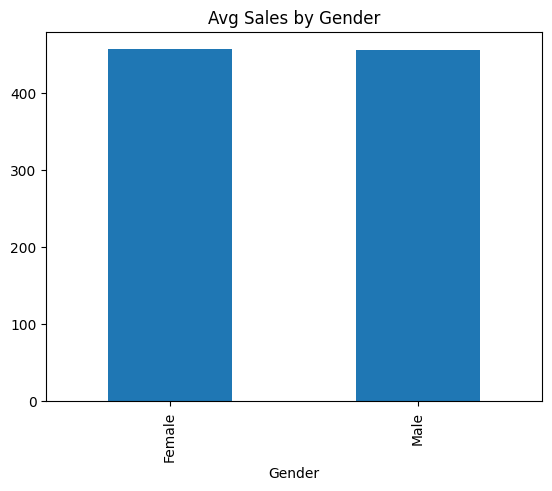

In [10]:
df.groupby('Gender')['Total Amount'].mean().plot(kind='bar', title='Avg Sales by Gender')

**Statistical Analysis**

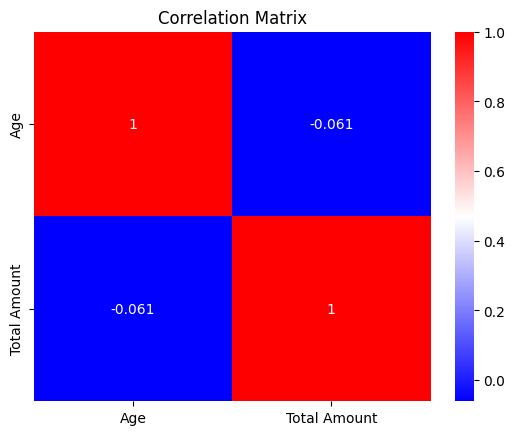

In [11]:
corr = df[['Age', 'Total Amount']].corr()
sns.heatmap(corr, annot=True, cmap='bwr')
plt.title("Correlation Matrix")
plt.show()

hampir tidak ada hubungan antara usia dengan Total_amount karena nilai korelasi sangat kecil

Melakukan uji t dua sampel

In [12]:
from scipy.stats import ttest_ind

male = df[df['Gender'] == 'Male']['Total Amount']
female = df[df['Gender'] == 'Female']['Total Amount']

t_stat, p_val = ttest_ind(male, female, equal_var=False)
print('T-Statistic:', t_stat)
print('P-Value:', p_val)

T-Statistic: -0.03159971766107415
P-Value: 0.9747976108130165


t_stat nilai statistik t menunjukkan seberapa ebsar perbedaaan relatif antara rata2 kelompok dibandingkan dengan vairasi datanya, p_Val probabilitas tidak signifikan secara statistik

p_val > 0.05 tidak ada perbedaan signifikan , tidak ada cukup bukti bahwa rata2 total amount pria wanita berbeda, t_stat negatif artinya bahwa total amount kelompok pria lebih kecil

Uji F (Anova)

In [13]:
from scipy.stats import f_oneway
grouped = [group['Total Amount'].values for name, group in df.groupby('Product Category')]
f_stat, p_val = f_oneway(*grouped)
print('F-Statistic:', f_stat)
print('P-Value:', p_val)

F-Statistic: 0.159430595139859
P-Value: 0.8526508750301867


Tujuan uji F (ANOVA One-Way):
“Apakah rata-rata Total Amount berbeda secara signifikan antar kategori produk (Beauty, Clothing, Electronics)?
ANOVA menguji perbedaan rata-rata antar lebih dari dua grup.

Null hypothesis 
H0 : Semua grup punya rata-rata yang sama.

Alternate hypothesis 
𝐻1 : Setidaknya ada satu grup yang berbeda rata-ratanya.

karena p-value kurang dari 0.05 tolak ho tidak ada perbedaan signifikan antara 3 jenis produk dalam hal penjualan, artinya Customer membelanjakan jumlah yang kira-kira sama, apakah mereka beli Beauty, Clothing, atau Electronics Rata-rata jumlah uang yang dikeluarkan oleh customer per transaksi itu mirip untuk semua kategori produk (kebetulan saja)

Uji Tukey

In [83]:
# tukey test 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Misalnya df punya kolom: Total Amount dan Product Category
tukey = pairwise_tukeyhsd(endog=df['Total Amount'],
                          groups=df['Product Category'],
                          alpha=0.05)

print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1     group2   meandiff p-adj    lower    upper   reject
--------------------------------------------------------------
  Beauty    Clothing -24.2277 0.8449  -127.028  78.5726  False
  Beauty Electronics   -8.689 0.9788 -112.1185  94.7405  False
Clothing Electronics  15.5387 0.9292  -84.4163 115.4936  False
--------------------------------------------------------------


Null hypothesis 
H0 : Semua grup punya rata-rata yang sama/ tidak ada perbedaan.

Alternate hypothesis 
𝐻1 : Setidaknya ada satu grup yang berbeda rata-ratanya.

for example first pair for beauty category product and clothing category product there is no fact/ or its just based coincedence when the costumer is spendd les in beuty category product rather than in clothing product.

Uji Two way Anova (Kombinasi 2 faktor Gender & Product Category)

In [84]:
#two way anova 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Two-Way ANOVA
model = ols('Q("Total Amount") ~ C(Gender) + C(Q("Product Category")) + C(Gender):C(Q("Product Category"))', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                          sum_sq     df         F    PR(>F)
C(Gender)                           5.792544e+01    1.0  0.000184  0.989179
C(Q("Product Category"))            9.990678e+04    2.0  0.158705  0.853270
C(Gender):C(Q("Product Category"))  3.154519e+05    2.0  0.501105  0.606014
Residual                            3.128681e+08  994.0       NaN       NaN


p significancy on the exact right column we can conclude that even the gender or the product category or even both combination of those variable dosnt have impact on our total sales.

Uji Chi Square ( Apakah Wanita lebih memiliki preferensi untuk membeli produk kategori Beauty, dibanding yang lain ?)

In [25]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Gender'], df['Product Category'])
chi2, p, dof, expected = chi2_contingency(contingency)
print('Chi-Square:', chi2)
print('P-Value:', p)

Chi-Square: 1.673837085800602
P-Value: 0.43304287262068974


Null hypothesis 
H0 : Semua grup punya rata-rata yang sama/ tidak ada perbedaan.

Alternate hypothesis 
𝐻1 : Setidaknya ada satu grup yang berbeda rata-ratanya.

p value greater than 0.05, then acc Ho, its mean there is not enough statistical eveidence to state that there is a siginificant relationship between gender and product category, on business implication we can conclude that between male and female customer choose product categories proportionally similiar way.  

#lanjutan bisa lebih spesifik misal gender male ke beberapa produc category dan seterusnya 

**Additional (Forecasting)**

Forecasting menggunakan MA3

In [14]:
df_forecasting = df.copy()
df_forecasting = df_forecasting.sort_values(by='Date').reset_index(drop=True)

In [15]:
df_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [16]:
df['Date'] = pd.to_datetime(df['Date'])

# 2. Buat kolom period bulanan (atau harian/mingguan sesuai kebutuhan)
df['Period'] = df['Date'].dt.to_period('M')

# 1. Group dan jumlahkan total per kategori per bulan
grouped = df.groupby(['Period', 'Product Category'])['Total Amount'].sum().reset_index()

# 2. Pivot agar kategori menjadi kolom
pivot_df = grouped.pivot(index='Period', columns='Product Category', values='Total Amount')

# 3. (Opsional) Ganti nama kolom supaya rapi (tanpa multiindex)
pivot_df.columns.name = None
pivot_df = pivot_df.fillna(0)
pivot_df
# 4. Tampilkan hasil


,Beauty,Clothing,Electronics
Period,,,
2023-01,12430.0,13125.0,9895.0
2023-02,14035.0,14560.0,15465.0
2023-03,10545.0,15065.0,3380.0
2023-04,11905.0,13940.0,8025.0
2023-05,12450.0,17455.0,23245.0
2023-06,10995.0,10170.0,15550.0
2023-07,16090.0,8250.0,11125.0
2023-08,9790.0,12455.0,14715.0
2023-09,6320.0,9975.0,7325.0


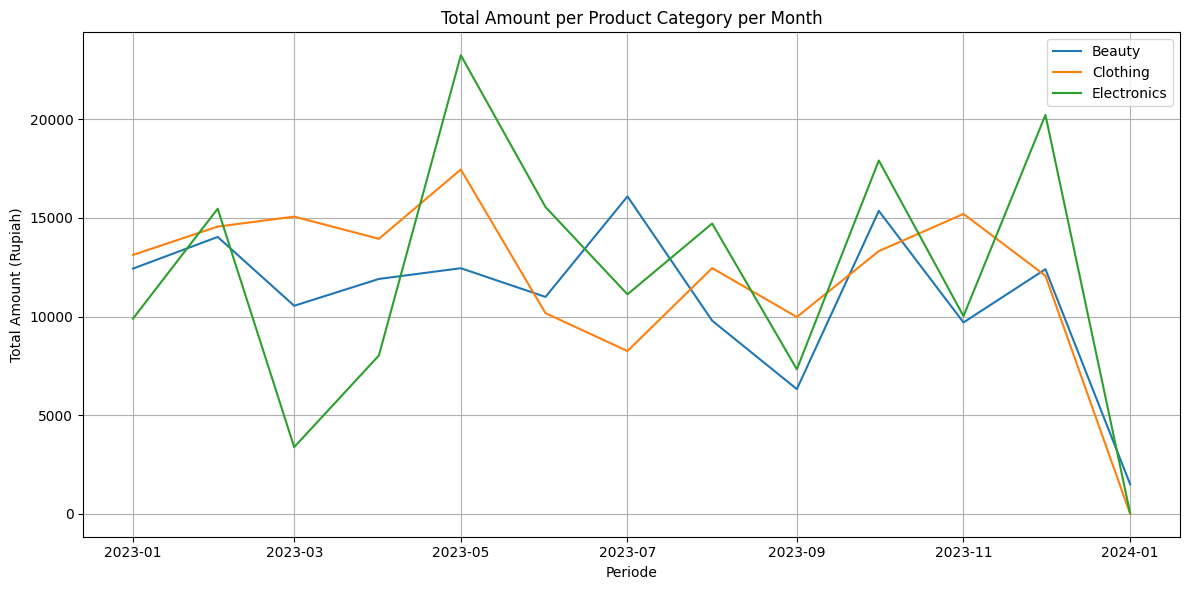

In [17]:
plt.figure(figsize=(12, 6))

for col in pivot_df.columns:
    plt.plot(pivot_df.index.to_timestamp(), pivot_df[col], label=col)

plt.title('Total Amount per Product Category per Month')
plt.xlabel('Periode')
plt.ylabel('Total Amount (Rupiah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pivot_df.to_excel(r'C:\Users\X1\Desktop\penjualan_retail.xlsx', index=False)
print('Berhasil disimpan')

Berhasil disimpan


Forecasting untuk produk kategori Beauty

In [24]:
series1 = pivot_df['Beauty'].copy()

forecast_periods = 3
window = 3

# Simpan hasil forecast di dict/series baru
forecast_values = []

# Buat list nilai gabungan antara data asli + forecast (dimulai dari data asli)
history = list(series1.values)

for i in range(forecast_periods):
    if len(history) < window:
        # Kalau kurang dari 3, rata-rata semua yang ada
        ma = sum(history) / len(history)
    else:
        ma = sum(history[-window:]) / window
    
    forecast_values.append(ma)
    history.append(ma)  # Tambahkan forecast ke history supaya bisa dipakai untuk bulan berikutnya

# Buat index tanggal untuk periode forecast
last_period = series1.index[-1]
future_periods = [last_period + i for i in range(1, forecast_periods + 1)]

# Buat dataframe hasil forecast
forecast_df = pd.DataFrame({'Period': future_periods, 'Beauty_MA3_Forecast': forecast_values})
forecast_df.set_index('Period', inplace=True)
print(forecast_df)

         Beauty_MA3_Forecast
Period                      
2024-02          7866.666667
2024-03          7255.555556
2024-04          5540.740741


In [25]:
#penggabungan data

# Buat dataframe data asli 'Beauty'
historical_df = pivot_df[[ 'Beauty']].copy()
historical_df = historical_df.rename(columns={'Beauty': 'Sales'})


combined_df = pd.concat([historical_df,
                         forecast_df.rename(columns={'Beauty_MA3_Forecast': 'Sales'})])

combined_df



,Sales
Period,
2023-01,12430.000000
2023-02,14035.000000
2023-03,10545.000000
2023-04,11905.000000
2023-05,12450.000000
2023-06,10995.000000
2023-07,16090.000000
2023-08,9790.000000
2023-09,6320.000000


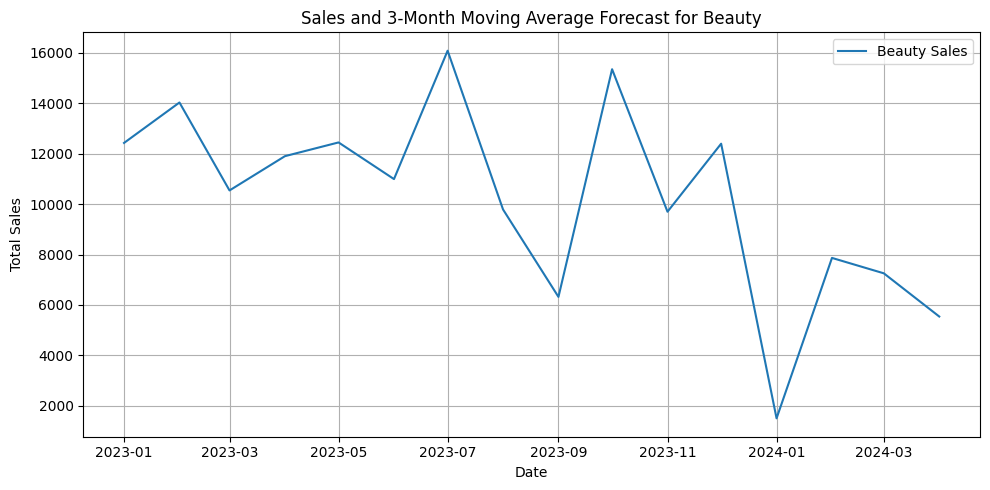

In [30]:
#plot
# 4. Plot
plt.figure(figsize=(10,5))

plt.plot(combined_df.index.to_timestamp(), combined_df['Sales'], label='Beauty Sales')
plt.title('Sales and 3-Month Moving Average Forecast for Beauty')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Forecasting menggunakan Machine learning (LSTM)


In [36]:
df_lstm = df.copy()
df_lstm['Date'] = pd.to_datetime(df_lstm['Date'])

# 2. Buat kolom period bulanan (atau harian/mingguan sesuai kebutuhan)
df_lstm['Period'] = df_lstm['Date'].dt.to_period('D')

# 1. Group dan jumlahkan total per kategori per bulan
grouped = df_lstm.groupby(['Period', 'Product Category'])['Total Amount'].sum().reset_index()

# 2. Pivot agar kategori menjadi kolom
pivot_df2 = grouped.pivot(index='Period', columns='Product Category', values='Total Amount')

# 3. (Opsional) Ganti nama kolom supaya rapi (tanpa multiindex)
pivot_df2.columns.name = None
pivot_df2 = pivot_df2.fillna(0)
pivot_df2
# 4. Tampilkan hasil

,Beauty,Clothing,Electronics
Period,,,
2023-01-01,1500.0,2100.0,0.0
2023-01-02,25.0,1650.0,90.0
2023-01-03,600.0,0.0,0.0
2023-01-04,1090.0,150.0,0.0
2023-01-05,50.0,0.0,1050.0
...,...,...,...
2023-12-27,100.0,0.0,600.0
2023-12-28,0.0,2000.0,75.0
2023-12-29,3300.0,0.0,100.0


In [38]:
zero_counts = (pivot_df2 == 0).sum()
print(zero_counts)

Beauty         141
Clothing       113
Electronics    126
dtype: int64


In [47]:
data_clothing = pivot_df2[['Clothing']]

train_size = int(len(data_clothing) * 0.7)
test_size = int(len(data_clothing) * 0.3)

data_train = data_clothing.iloc[:train_size]  # Dari awal sampai 70%
data_test = data_clothing.iloc[train_size:]

print("Train size:", data_train.shape)
print("Test size:", data_test.shape)

data_clothing

Train size: (241, 1)
Test size: (104, 1)


,Clothing
Period,
2023-01-01,2100.0
2023-01-02,1650.0
2023-01-03,0.0
2023-01-04,150.0
2023-01-05,0.0
...,...
2023-12-27,0.0
2023-12-28,2000.0
2023-12-29,0.0


In [48]:
data_train1=data_train.reset_index()["Clothing"]
data_test1= data_test.reset_index()["Clothing"]
data_train1.head()

0    2100.0
1    1650.0
2       0.0
3     150.0
4       0.0
Name: Clothing, dtype: float64

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

data_train1 = scaler.fit_transform(data_train1.values.reshape(-1,1))
data_test1 = scaler.transform(data_test1.values.reshape(-1,1))

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [51]:
time_step = 10
X_train, y_train = create_dataset(data_train1, time_step)
X_test, y_test = create_dataset(data_test1, time_step)

In [53]:
print(X_train.shape)

(230, 10)


In [57]:
print(y_train.shape)

(230,)


In [63]:
X_train1 =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test1 = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [66]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
model.add(Dropout(0.2))  # Dropout 20%
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=16,verbose=1)

Epoch 1/50

15/15 [==============================] - 8s 106ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0348 - val_loss: 0.0409
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0351 - val_loss: 0.0407
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0342 - val_loss: 0.0404
Epoch 5/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0340 - val_loss: 0.0403
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0346 - val_loss: 0.0404
Epoch 7/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0339 - val_loss: 0.0401
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0347 - val_loss: 0.0400
Epoch 9/50
15/15 [==============================] - 0s 16ms/step - loss: 0.0340 - val_loss: 0.0398
Epoch 10/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0337 - val_loss: 0.0402
Epoch 1

In [68]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 6ms/step


In [69]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [70]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_error = np.sqrt(mean_squared_error(y_train, train_predict))
test_error = np.sqrt(mean_squared_error(y_test, test_predict))

print(f"Train RMSE: {train_error}")
print(f"Test RMSE: {test_error}")

Train RMSE: 448.8525633102669
Test RMSE: 446.05920001750985


RMSE termasuk masih besar model masih belum optimal, kita akan perbaiki nanti 

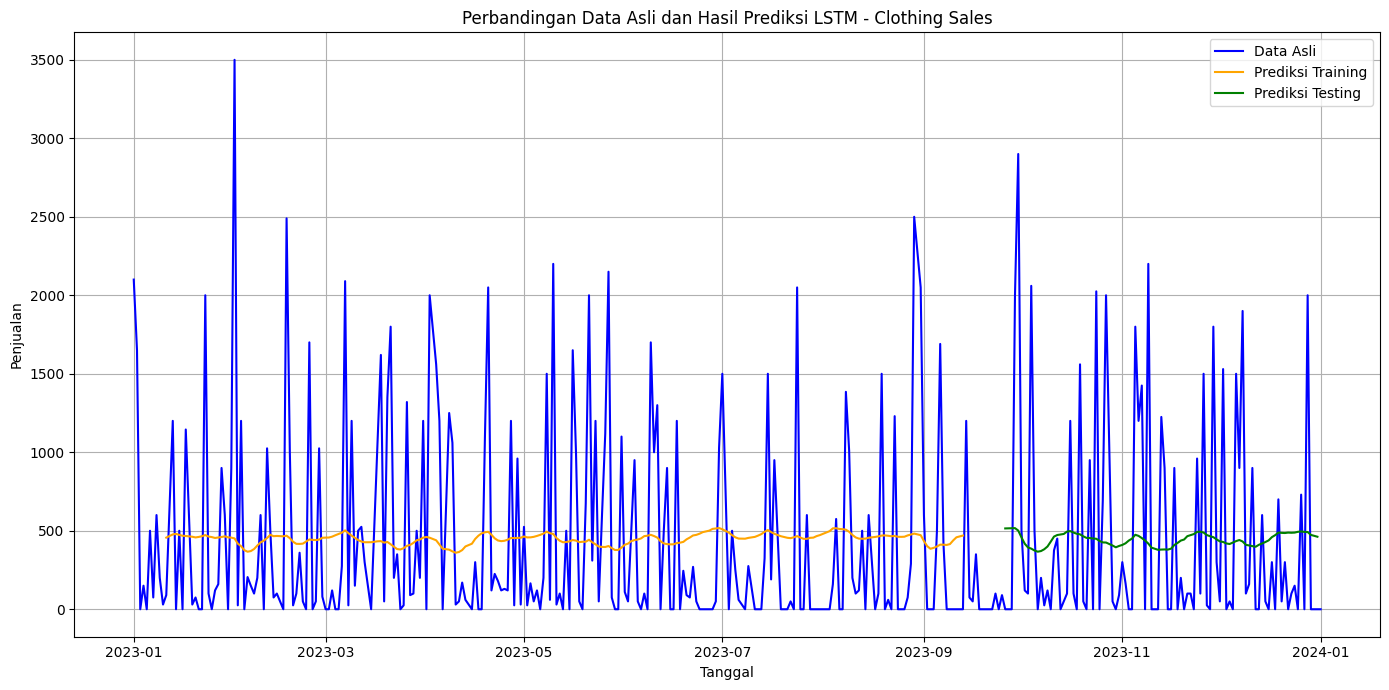

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asumsi data_clothing sudah ada
# Asumsi train_predict dan test_predict bentuk (n, 1)
look_back = 10
# Inisialisasi array kosong (dengan NaN) untuk prediksi training dan testing
trainPredictPlot = np.empty_like(data_clothing['Clothing'].values.reshape(-1,1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : look_back + len(train_predict), :] = train_predict

testPredictPlot = np.empty_like(data_clothing['Clothing'].values.reshape(-1,1))
testPredictPlot[:, :] = np.nan
test_start = look_back + len(train_predict) + 1 +10
testPredictPlot[test_start : test_start + len(test_predict), :] = test_predict

# Plot data asli dan prediksi
plt.figure(figsize=(14, 7))
plt.plot(data_clothing.index.to_timestamp(), data_clothing['Clothing'], label='Data Asli', color='blue')
plt.plot(data_clothing.index.to_timestamp(), trainPredictPlot, label='Prediksi Training', color='orange')
plt.plot(data_clothing.index.to_timestamp(), testPredictPlot, label='Prediksi Testing', color='green')

plt.title('Perbandingan Data Asli dan Hasil Prediksi LSTM - Clothing Sales')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Hasil prediksi dengan aktual cukup jauh, model tidak cukup belajar mengenali pola terutama karena data terbatas 